In [1]:
%matplotlib inline 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from pandas_profiling import ProfileReport
import numpy as np

In [2]:
df = pd.read_csv('data/data_Inmeta.csv', sep=';', header=0)
df.head(20)

,Y,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,13500,23,46986,1.0,90,1,0,2000,3,1165
1,13750,23,72937,1.0,90,1,0,2000,3,1165
2,13950,24,41711,1.0,90,1,0,2000,3,1165
3,14950,26,48000,1.0,90,0,0,2000,3,1165
4,13750,30,38500,1.0,90,0,0,2000,3,1170
5,12950,32,61000,1.0,90,0,0,2000,3,1170
6,16900,27,94612,1.0,90,1,0,2000,3,1245
7,18600,30,75889,1.0,90,1,0,2000,3,1245
8,21500,27,19700,0.0,192,0,0,1800,3,1185
9,12950,23,71138,1.0,69,0,0,1900,3,1105


# Exploratory Data Analysis

In [3]:
print(df.describe())
print(df.info())

                  Y    Feature 1      Feature 2   Feature 3    Feature 4  \
count   1436.000000  1436.000000    1436.000000  414.000000  1436.000000   
mean   10730.824513    55.947075   68533.259749    0.173913   101.502089   
std     3626.964585    18.599988   37506.448872    0.379493    14.981080   
min     4350.000000     1.000000       1.000000    0.000000    69.000000   
25%     8450.000000    44.000000   43000.000000    0.000000    90.000000   
50%     9900.000000    61.000000   63389.500000    0.000000   110.000000   
75%    11950.000000    70.000000   87020.750000    0.000000   110.000000   
max    32500.000000    80.000000  243000.000000    1.000000   192.000000   

         Feature 5    Feature 6    Feature 7    Feature 8   Feature 9  
count  1436.000000  1436.000000  1436.000000  1436.000000  1436.00000  
mean      0.674791     0.055710  1566.827994     4.033426  1072.45961  
std       0.468616     0.229441   187.182436     0.952677    52.64112  
min       0.000000     0.00

* Binary features: 3, 5, 6 
* Mising values: 3

<AxesSubplot:>

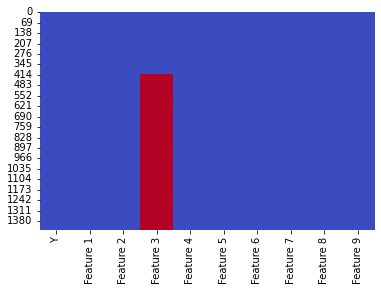

In [4]:
sns.heatmap(df.isnull(), cmap='coolwarm', cbar=False)

<AxesSubplot:>

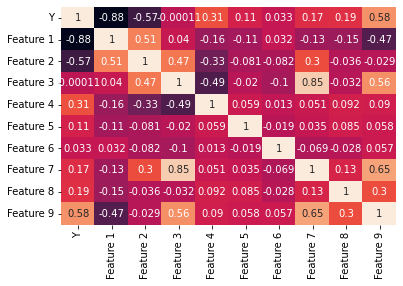

In [5]:
sns.heatmap(df.corr(), annot=True, cbar=False)

In [6]:
# Find the duplications
df[df.duplicated(keep=False)]

,Y,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
112,24950,8,13253,1.0,116,1,0,2000,5,1320
113,24950,8,13253,1.0,116,1,0,2000,5,1320


22250.0


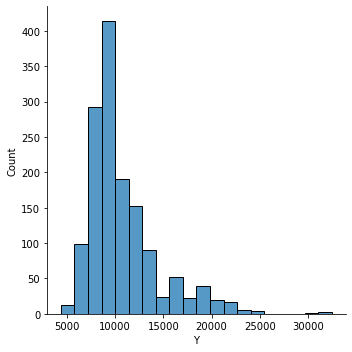

In [7]:
sns.displot(df['Y'], bins=20)
print(np.percentile(df['Y'], q=99))

In [8]:
# # Pandas profiling
# profile = ProfileReport(df)
# profile

# Data Preprocessing

In [9]:
# Drop column feature 3
df_clean = df.drop('Feature 3', axis=1)
# Drop duplicates
df_clean = df_clean.drop_duplicates(keep='first')

In [10]:
print('Missing values by column: ', df_clean.isnull().any())
print('No duplicate ', df_clean.duplicated().any())

Missing values by column:  Y            False
Feature 1    False
Feature 2    False
Feature 4    False
Feature 5    False
Feature 6    False
Feature 7    False
Feature 8    False
Feature 9    False
dtype: bool
No duplicate  False


In [11]:
threshold = np.percentile(df_clean['Y'], q=99)

# threshold = np.mean(df_clean['Y']) + np.std(df_clean['Y'])
# threshold = 30000
print('threshold ', threshold)
df_clean = df_clean[df_clean['Y'] <= threshold]
print('Shape after filter ', df_clean.shape)

threshold  22250.0
Shape after filter  (1422, 9)


In [12]:
# Train test split
X = df_clean.drop('Y', axis=1)
# X = np.array(df_clean['Feature 1']).reshape(-1, 1)
y = df_clean['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


# Utils

In [13]:
#Visualization code

def vis(y_test, y_pred):

    # Distribution on the line
    fig, ax = plt.subplots(3, 1, figsize=(20,20))
    ax[0].scatter(y_pred, y_test, color='red')
    ax[0].set_xlabel('Predictions', fontsize = 15)
    ax[0].set_ylabel('Ground truths', fontsize = 15)
    ax[0].set_title('Predictions x Ground truths on dataset', fontsize = 15)
    ax[0].plot([0, max(y_test)], [0, max(y_test)], 'g--')

    # Scatter overlapping
    x = range(len(y_test))
    ax[1].scatter(x, y_test, color='blue', label='Ground truth', marker='o')
    ax[1].scatter(x, y_pred, color='green', label='Predictions', marker='x')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Scatter plot of ground truth and prediction', fontsize = 15)

    # Residual histogram
    sns.histplot(abs(y_pred - y_test), ax=ax[2], bins=10)
    ax[2].set_title('Residuals distribution', fontsize = 15)
    
    print('RMSE', mean_squared_error(y_test, y_pred, squared=False))
    print('MSE:', mean_squared_error(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('r2_score: ', r2_score(y_test, y_pred))


    plt.show()
    

In [14]:
def read_cv_test_result(cv_dict, cv=5):
    
    for key in cv_dict.keys():
        if key.startswith('test'):
            print('Average {}-fold '.format(cv)+key)
            print(cv_dict[key].mean())
    
    print(pd.DataFrame(cv_dict).head(20))

# Data modelling

In [15]:
cv_scoring_metrics = ('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_root_mean_squared_error')
folds = KFold(n_splits=5, shuffle=True, random_state=123)

## Linear Regression

RMSE 1370.5563542182394
MSE: 1878424.7200879925
MAE:  1036.137647976635
r2_score:  0.8414686586053268


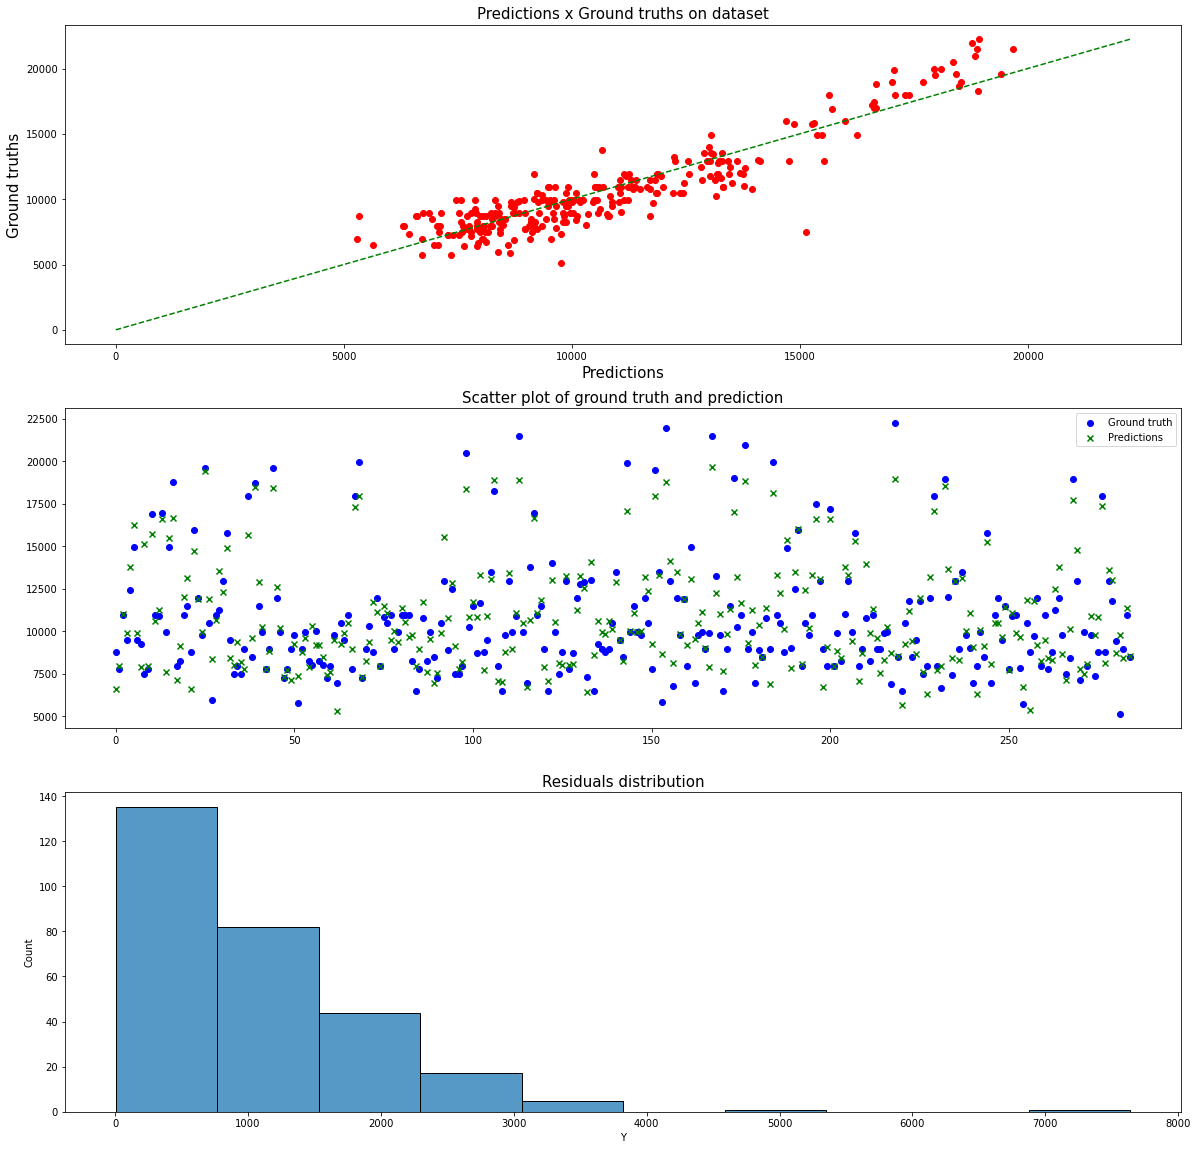

In [16]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
vis(y_test, y_predict)

In [17]:
# Cross validation
lr_cv_scores = cross_validate(lr, X, y, cv=folds, scoring=cv_scoring_metrics)
read_cv_test_result(lr_cv_scores)

Average 5-fold test_r2
0.845333439351639
Average 5-fold test_neg_mean_squared_error
-1699557.530635545
Average 5-fold test_neg_mean_absolute_error
-953.9738695143624
Average 5-fold test_neg_root_mean_squared_error
-1300.7129657243338
   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.003001    0.003001  0.841469                -1.878425e+06   
1  0.001998    0.002001  0.836170                -1.793043e+06   
2  0.002000    0.001000  0.869064                -1.451171e+06   
3  0.001000    0.001999  0.808465                -1.964442e+06   
4  0.001999    0.000999  0.871500                -1.410706e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                  -1036.137648                      -1370.556354  
1                   -951.397820                      -1339.045701  
2                   -942.889805                      -1204.645615  
3                   -916.632054                      -1401.585687  
4                   -922.8120

## Decision Tree

RMSE 1480.7993644970059
MSE: 2192766.7578947367
MAE:  1137.8035087719297
r2_score:  0.8149394799923537


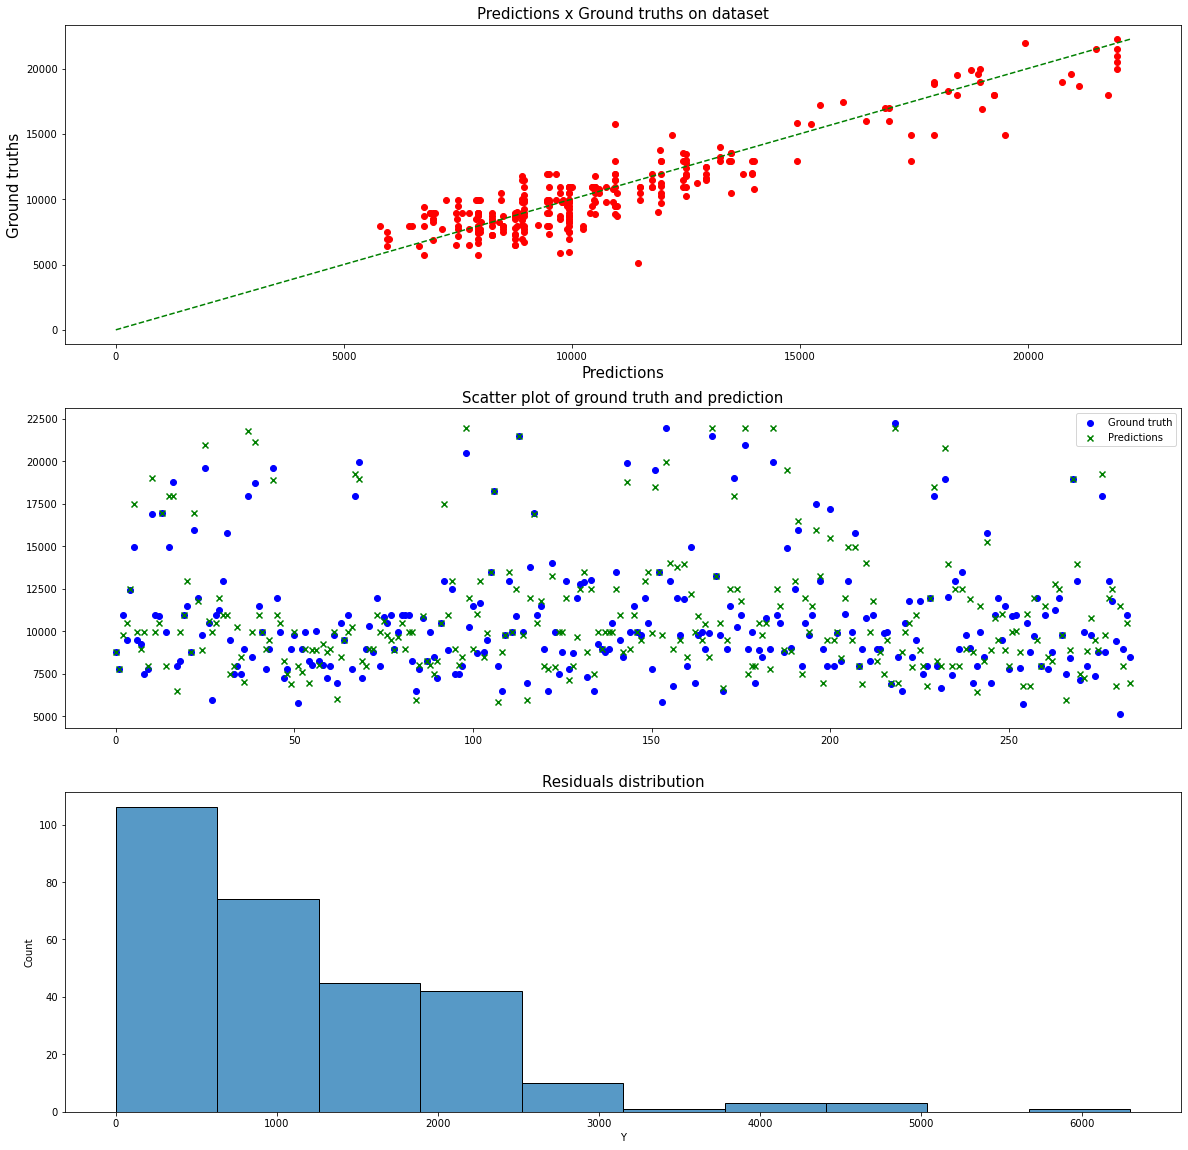

In [18]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
dc = DecisionTreeRegressor()
dc.fit(X_train, y_train)
dc_pred = dc.predict(X_test)
vis(y_test, dc_pred)

In [19]:
dc_cv_scores = cross_validate(dc, X, y, cv=folds, scoring=cv_scoring_metrics)
read_cv_test_result(dc_cv_scores)

Average 5-fold test_r2
0.8240200706802747
Average 5-fold test_neg_mean_squared_error
-1940479.9025228568
Average 5-fold test_neg_mean_absolute_error
-1074.016671608599
Average 5-fold test_neg_root_mean_squared_error
-1390.6291280367986
   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.005040    0.001963  0.816395                -2.175518e+06   
1  0.005025    0.002013  0.793510                -2.259936e+06   
2  0.003999    0.001010  0.844303                -1.725606e+06   
3  0.003947    0.002040  0.824681                -1.798122e+06   
4  0.004030    0.001000  0.841211                -1.743217e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                  -1122.943860                      -1474.963872  
1                  -1165.382456                      -1503.308349  
2                  -1037.894366                      -1313.623234  
3                  -1010.778169                      -1340.940653  
4                  -1033.08

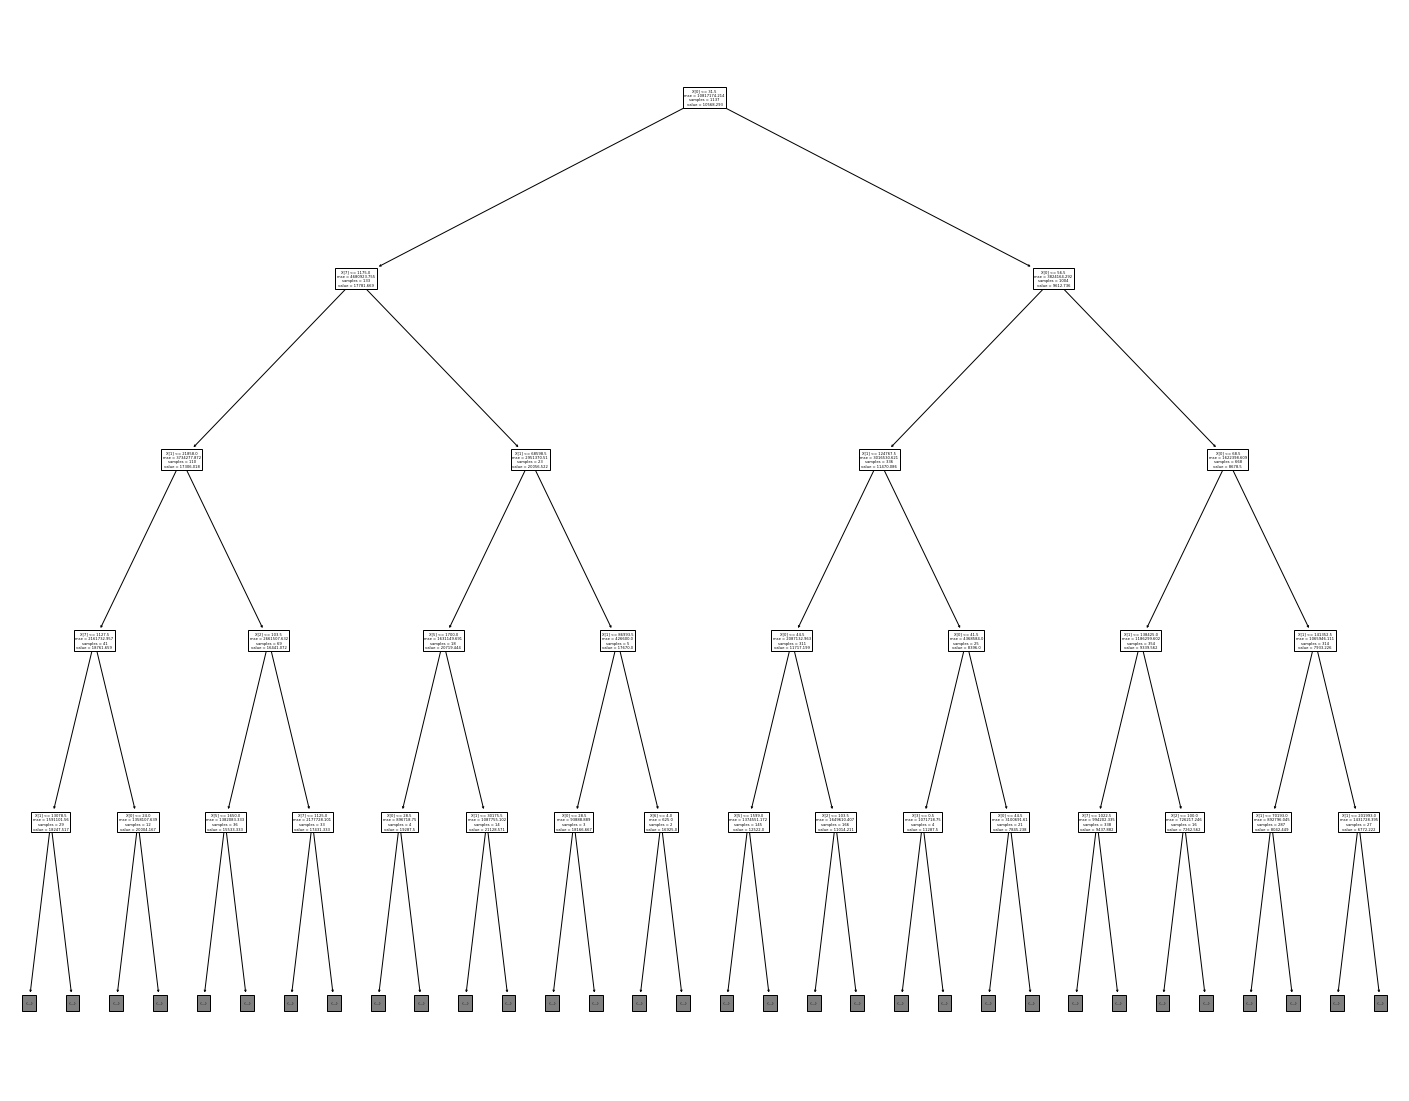

In [20]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dc, max_depth=4)


## Random Forest

RMSE 1155.8449904723384
MSE: 1335977.642
MAE:  880.3284912280702
r2_score:  0.887248966969711


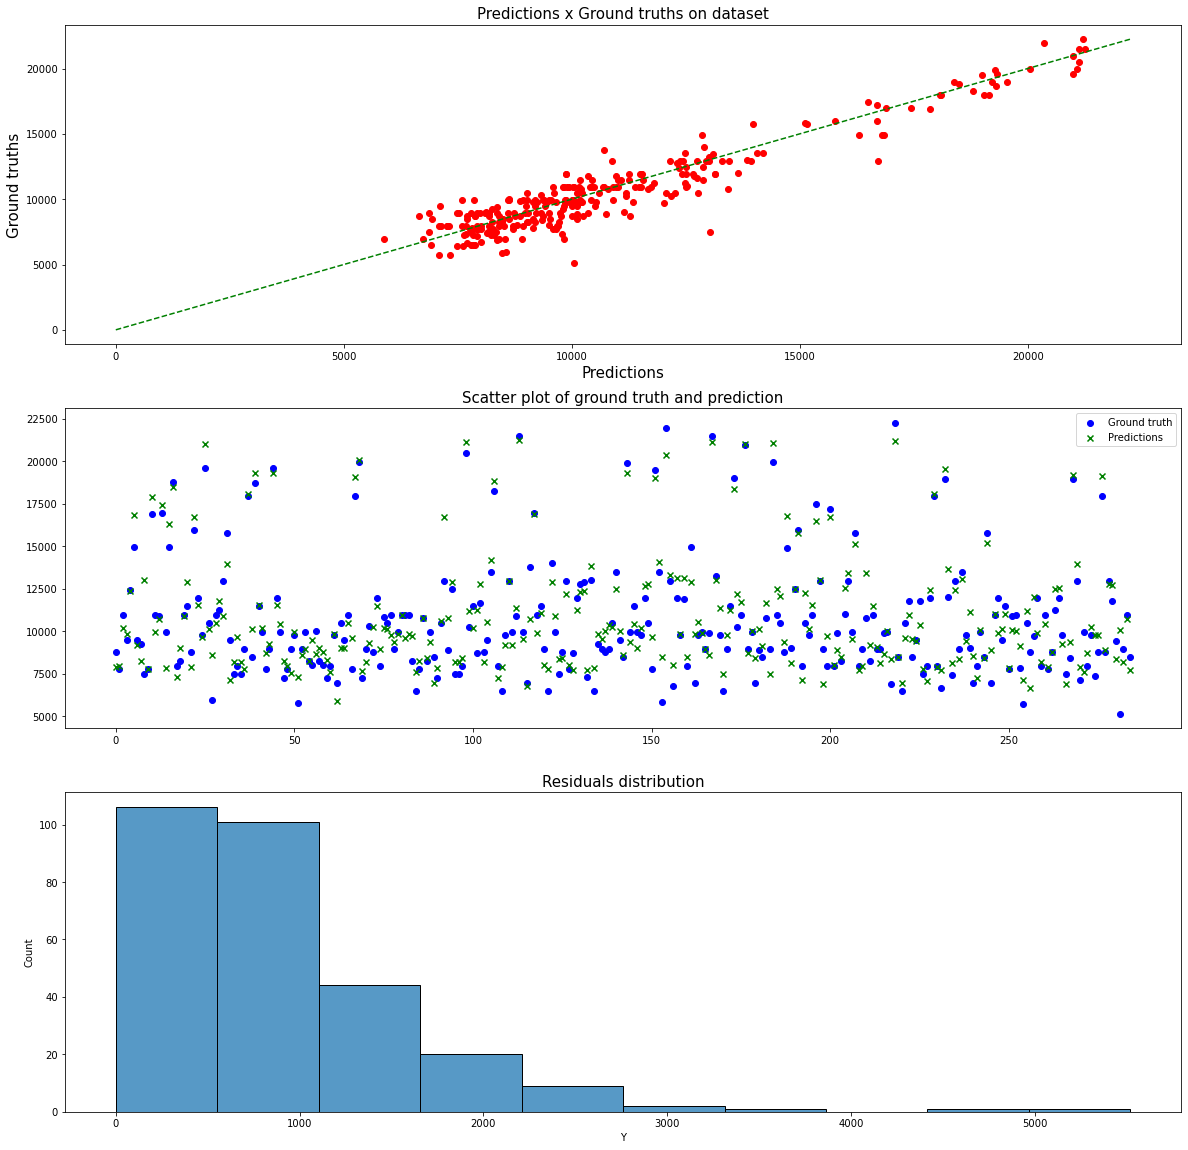

In [21]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)
vis(y_test, rf_predict)

In [22]:
rf_cv_scores = cross_validate(rf, X, y, cv=folds, scoring=cv_scoring_metrics)
read_cv_test_result(rf_cv_scores)

Average 5-fold test_r2
0.8901536656316879
Average 5-fold test_neg_mean_squared_error
-1210067.694497326
Average 5-fold test_neg_mean_absolute_error
-837.3490973478296
Average 5-fold test_neg_root_mean_squared_error
-1097.774185430717
   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.266798    0.010001  0.883033                -1.385936e+06   
1  0.256998    0.010001  0.875210                -1.365768e+06   
2  0.257048    0.010954  0.905877                -1.043171e+06   
3  0.262943    0.010044  0.879826                -1.232543e+06   
4  0.257818    0.011003  0.906823                -1.022921e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                   -899.890982                      -1177.257682  
1                   -875.810784                      -1168.660666  
2                   -808.111784                      -1021.357562  
3                   -818.749789                      -1110.199395  
4                   -784.1821

In [23]:
# feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
# feat_importances.nlargest(20).plot(kind='bar')

## XGBoost

RMSE 1197.5119539352584
MSE: 1434034.8798178404
MAE:  922.3676500822369
r2_score:  0.8789733383121034


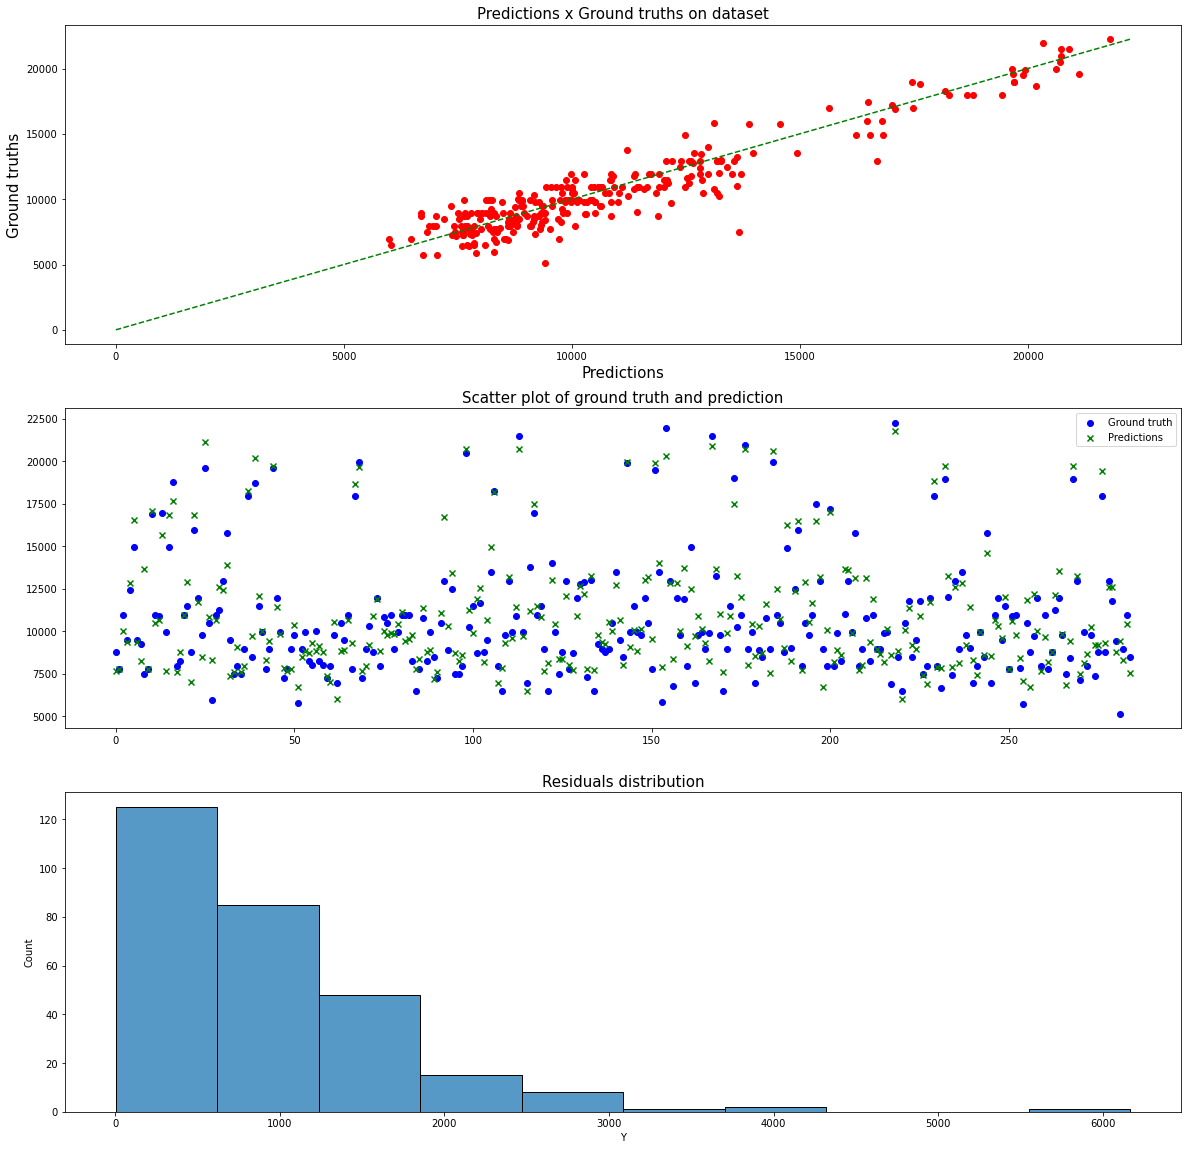

In [24]:
from xgboost import XGBRegressor
xg = XGBRegressor()
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_test)
vis(y_test, xg_pred)

<AxesSubplot:>

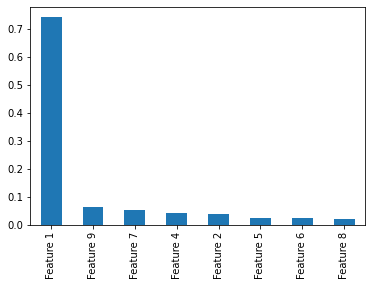

In [25]:
feat_importances = pd.Series(xg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='bar')

In [26]:
xg_cv_scores = cross_validate(xg, X, y, cv=folds, scoring=cv_scoring_metrics)
read_cv_test_result(xg_cv_scores)

Average 5-fold test_r2
0.8795042712720699
Average 5-fold test_neg_mean_squared_error
-1325634.3097766016
Average 5-fold test_neg_mean_absolute_error
-870.9762244505961
Average 5-fold test_neg_root_mean_squared_error
-1148.8658706603005
   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.205000    0.007002  0.878973                -1.434035e+06   
1  0.210003    0.007998  0.857830                -1.555987e+06   
2  0.204288    0.006999  0.903221                -1.072604e+06   
3  0.210001    0.006999  0.866041                -1.373921e+06   
4  0.206034    0.008001  0.891456                -1.191625e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                   -922.367650                      -1197.511954  
1                   -916.965896                      -1247.392251  
2                   -809.608661                      -1035.665752  
3                   -870.147225                      -1172.143757  
4                   -835.79

## ANN

In [28]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential

In [41]:
ann = Sequential()
depth = 4
hidden_nodes = [30, 20, 20, 30]
ann.add(Input(shape=X_train.shape[1]))

for i in range(depth):
    if(isinstance(hidden_nodes, list)):
        ann.add(Dense(hidden_nodes[i], activation='relu'))
    elif(isinstance(hidden_nodes, int)):
        ann.add(Dense(hidden_nodes, activation='relu'))

ann.add(Dense(1, activation='linear'))
ann.summary()

ann.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error', 'mse'])

ann.fit(X_train, y_train, batch_size=32, epochs=1000)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 30)                270       
_________________________________________________________________
dense_21 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_22 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_23 (Dense)             (None, 30)                630       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 31        
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
36/36 [==============================] - 0s 830us/step - loss: 7985.5908 - mean_absolute_error: 7985.5908

RMSE 1309.7342942188973
MSE: 1715403.9214530727
MAE:  982.577264939693
r2_score:  0.8552269453263481


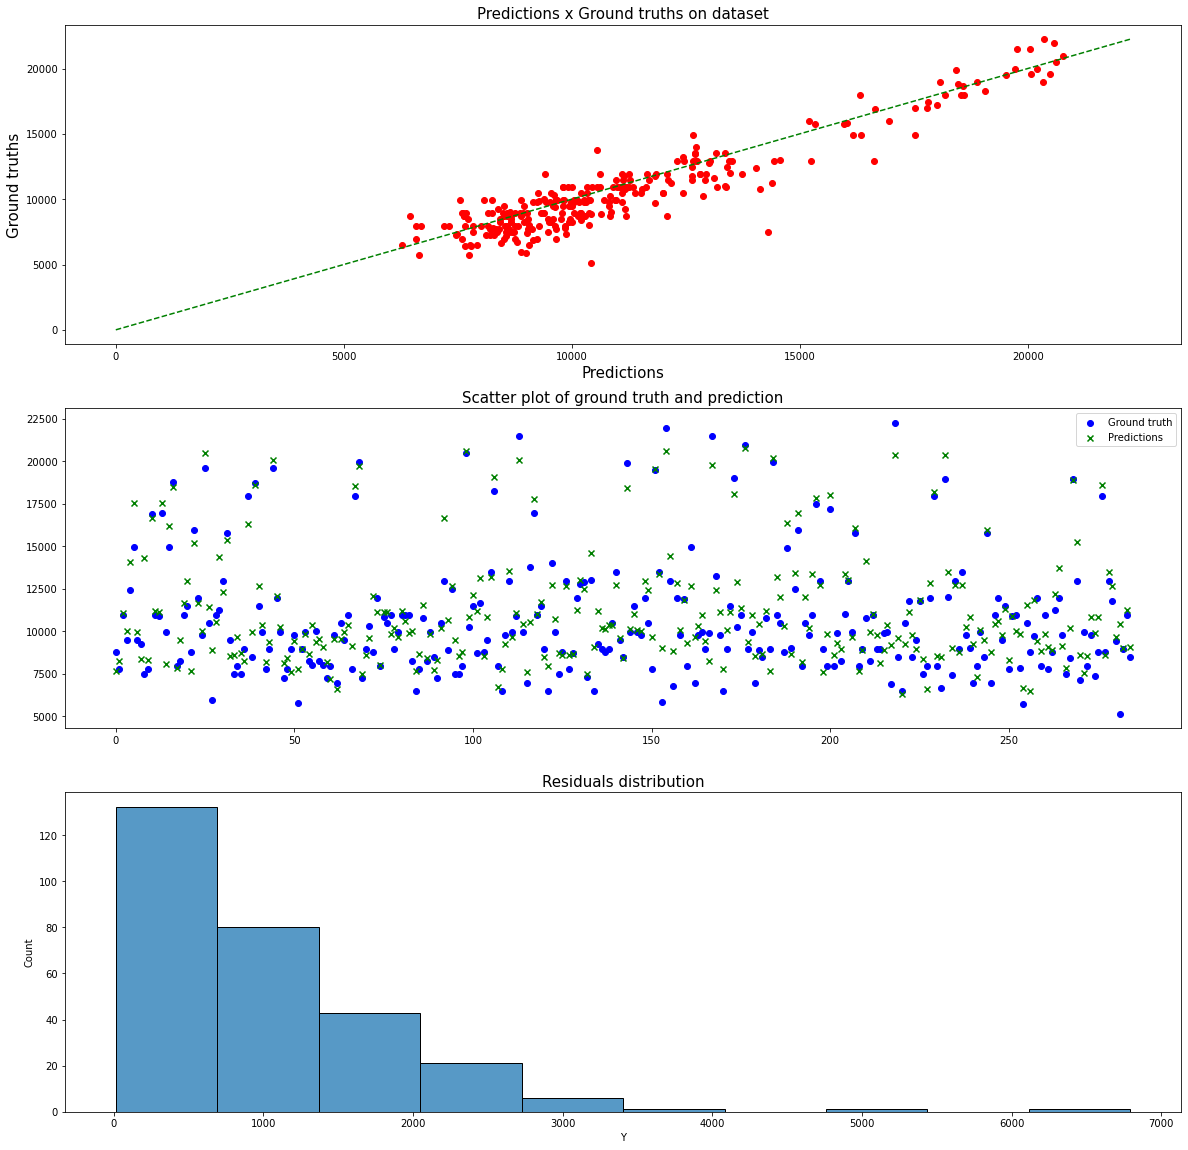

In [42]:
ann_pred = ann.predict(X_test)
vis(y_test, ann_pred.reshape(-1))